In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data=pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


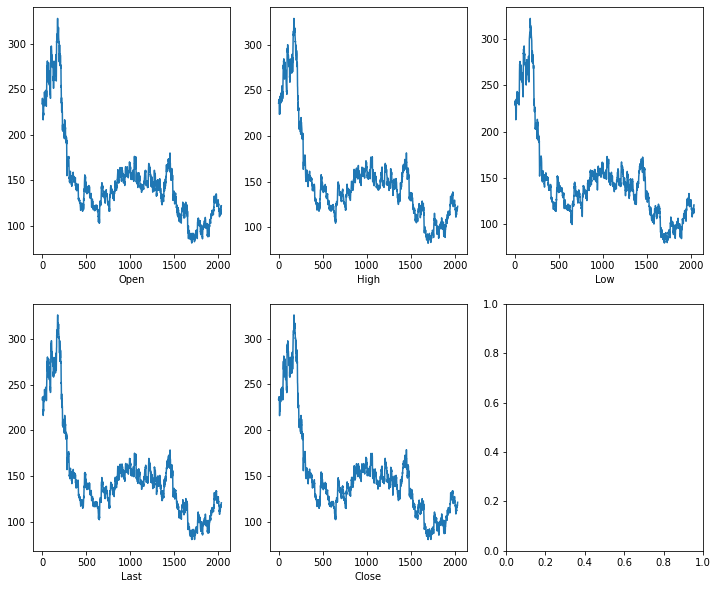

In [3]:
# data.reset_index()
column_labels = list(data.columns)
fig, axes = plt.subplots(2, 3, sharex='none',figsize=(12,10))
for i,feature in enumerate(column_labels[1:6]):
    row_index = i // 3  # Calculate row index for subplot
    col_index = i % 3   # Calculate column index for subplot

    axes[row_index, col_index].plot(data[feature])
    axes[row_index, col_index].set_xlabel(feature)
plt.show()

In [4]:
df1=data['Close']
df1

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.1621732 ],
       [0.16319444],
       [0.16584967]])

In [6]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train,test=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [7]:
# test.shape
len(train)

1322

In [8]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [9]:
time_step = 100
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

In [10]:
print(X_train.shape)
print(y_train.shape)

(1221, 100)
(1221,)


In [11]:
print(X_test.shape)
print(y_test.shape)

(612, 100)
(612,)


In [12]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)
X_train.shape
# X_test.shape

(1221, 100, 1)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [14]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
20/20 [==============================] - 11s 258ms/step - loss: 0.0295 - val_loss: 0.0048
Epoch 2/50
20/20 [==============================] - 5s 227ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 3/50
20/20 [==============================] - 4s 214ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 4/50
20/20 [==============================] - 4s 202ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/50
20/20 [==============================] - 4s 201ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/50
20/20 [==============================] - 4s 201ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 7/50
20/20 [==============================] - 4s 189ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 8/50
20/20 [==============================] - 4s 197ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 9/50
20/20 [==============================] - 4s 203ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/50
20/20 [==============================] - 4s 195ms/step - loss: 0.0012 - val_loss: 0.001

In [17]:
x_train_p=model.predict(X_train)
x_test_p=model.predict(X_test)

20/20 [==============================] - 1s 38ms/step


In [18]:
x_train_p.shape

(1221, 1)

In [19]:
train_predict=scaler.inverse_transform(x_train_p)
test_predict=scaler.inverse_transform(x_test_p)

In [20]:
import math
from sklearn.metrics import mean_squared_error
print(math.sqrt((mean_squared_error(y_train,train_predict))))

166.1442238046969


In [21]:
print(math.sqrt((mean_squared_error(y_test,test_predict))))

118.73913286997002


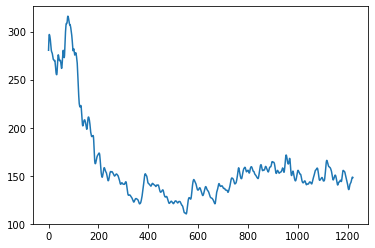

In [22]:
# test_predict
plt.plot(train_predict)

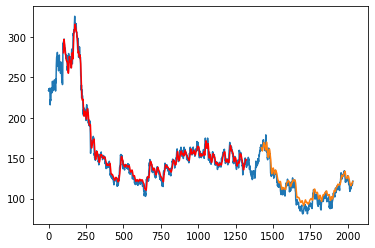

In [23]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot,color='red')
plt.plot(testPredictPlot)
plt.show()

In [24]:
# len(test_size)
len(test)

713

In [25]:
x_input=test[613:].reshape(1,-1)
x_input.shape

(1, 100)

In [26]:
x_input

array([[0.12479575, 0.13848039, 0.14011438, 0.13888889, 0.13541667,
        0.14011438, 0.1380719 , 0.13071895, 0.13071895, 0.12867647,
        0.11846405, 0.14644608, 0.14808007, 0.15910948, 0.15992647,
        0.15788399, 0.16441993, 0.17892157, 0.17933007, 0.19260621,
        0.20812908, 0.18974673, 0.18055556, 0.18239379, 0.17708333,
        0.17810458, 0.18055556, 0.17810458, 0.17851307, 0.19607843,
        0.18913399, 0.18954248, 0.19403595, 0.19444444, 0.20200163,
        0.19771242, 0.19934641, 0.19873366, 0.1997549 , 0.2128268 ,
        0.21568627, 0.20445261, 0.21772876, 0.21098856, 0.21425654,
        0.19750817, 0.18811275, 0.17851307, 0.17381536, 0.16033497,
        0.16564542, 0.17116013, 0.17422386, 0.18035131, 0.17401961,
        0.16278595, 0.16973039, 0.17810458, 0.17034314, 0.16830065,
        0.17279412, 0.17544935, 0.18382353, 0.19138072, 0.18913399,
        0.19097222, 0.17238562, 0.16830065, 0.1693219 , 0.17177288,
        0.16156046, 0.14971405, 0.1503268 , 0.15

In [27]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [30]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.17279412 0.17544935 0.18382353 0.19138072 0.18913399 0.19097222
 0.17238562 0.16830065 0.1693219  0.17177288 0.16156046 0.14971405
 0.1503268  0.15196078 0.14726307 0.14501634 0.14603758 0.12479575
 0.13112745 0.11397059 0.1190768  0.12377451 0.13562092 0.12908497
 0.13459967 0.12806373 0.13031046 0.12724673 0.13521242 0.14522059
 0.15257353 0.14848856 0.14338235 0.14562908 0.15236928 0.15400327
 0.14971405 0.1621732  0.16319444 0.16584967 0.16736209 0.16954465
 0.17177616 0.1739895  0.17614636 0.17822929 0.1802337  0.18216172
 0.18401839 0.18580975 0.18754146 0.18921877 0.19084632 0.19242817
 0.193968   0.1954689  0.19693369 0.19836481 0.19976439 0.20113418
 0.20247573 0.20379026 0.2050788  0.20634222 0.20758131 0.20879641
 0.20998818 0.21115699 0.21230304 0.21342687 0.21452859 0.21560857
 0.21666707 0.21770445 0.21872096 0.21971694 0.22069283 0.22164884
 0.22258541 0.22350295 0.22440185 0.22528246 0.22614525 0.2269906
 0.22781886 0.22863047 0.22942585 0.23020534 0.2309

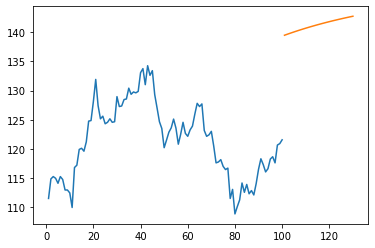

In [33]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)


plt.plot(day_new,scaler.inverse_transform(df1[1935:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [32]:
len(df1)

2035